In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

In [3]:
from querysnout.src.optimized_qbs import qbs

In [ ]:
import time

import nest_asyncio

from lnb.data_prep import load_data, split_data
from lnb.distance import compute_achilles, top_n_vulnerable_records
from lnb.mia import mia
from lnb.plots import calculate_statistics, plot_achilles, plot_mia_scores

nest_asyncio.apply()

# Load data

In [5]:
path_to_data = "../data/adult/Adult_dataset.csv"
path_to_metadata = "../data/adult/Adult_metadata_discretized.json"

Load the full Adult dataset:

In [6]:
df, categorical_cols, continuous_cols, meta_data = load_data(
    path_to_data, path_to_metadata
)

Split the dataset into auxiliary and evaluation, and get the target dataset from the evaluation pool.

In [7]:
df_aux, df_eval, df_target = split_data(df, "../data/adult/1000_indices.pickle")

# Who are the most vulnerable records?

Find the Achilles score of each record in the target dataset.

In [8]:
t1 = time.time()
all_dists = compute_achilles(
    df_target, categorical_cols, continuous_cols, meta_data, 5
)
t2 = time.time()

print(f"time taken = {(t2-t1)}")

creating tasks


1000it [00:00, 170417.03it/s]


computing achilles


100%|██████████| 1000/1000 [00:01<00:00, 889.10it/s]

time taken = 1.346100091934204


Find the top 10 most vulnerable records:

In [9]:
top_n_records = top_n_vulnerable_records(all_dists, 10)

Let's take a look at the Achilles risk scores of all the records in our target dataset:

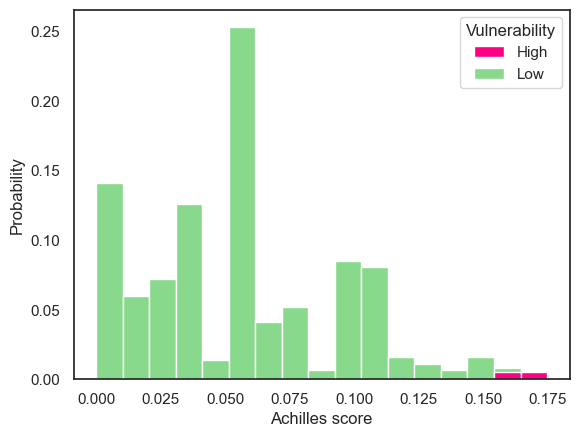

In [10]:
plot_achilles(all_dists, 10)

In [11]:
calculate_statistics(all_dists)

65.50% of the records in the target dataset have a below-average Achilles score.
The third quantile is 0.08, i.e. three quarters (75%) of the records have an Achilles score below 0.08.


The Achilles scores fall in the range between 0.0 and 0.175, with most lying on the lower end or towards the middle of the range. We see from the graph and the descriptive statistics that the risk is likely to lie with only a few high-risk records, with the other records being of low-to-medium risk.

# MIA risk score

Let's now calculate the risk scores using MIAs for the 5 records considererd most vulnerable by their Achilles score. In this notebook, we use 100 shadow and evaluation datasets to save on time, but in a real-life situation, this number should be carefully chosen to ensure stable results and the best possible MIA performance!

In [15]:

mia_results = mia(
    path_to_data=path_to_data,
    path_to_metadata=path_to_metadata,
    path_to_data_split="../data/adult/1000_indices.pickle",
    target_records=top_n_records[:5],
    generator_name="SYNTHPOP",
    n_synth=1000,
    n_datasets=100,
    epsilon=0.0,
    output_path="../output/files/",
)

  0%|          | 0/5 [00:00<?, ?it/s]

Generating shadow datasets...
Extracting training features...
training meta-classifier
['random_forest', 'logistic_regression']
Model: random_forest
Model: logistic_regression


 20%|██        | 1/5 [03:31<14:05, 211.29s/it]

Generating shadow datasets...
Extracting training features...
training meta-classifier
['random_forest', 'logistic_regression']
Model: random_forest
Model: logistic_regression


 40%|████      | 2/5 [07:09<10:46, 215.60s/it]

Generating shadow datasets...
Extracting training features...
training meta-classifier
['random_forest', 'logistic_regression']
Model: random_forest
Model: logistic_regression


 60%|██████    | 3/5 [10:41<07:07, 213.82s/it]

Generating shadow datasets...
Extracting training features...
training meta-classifier
['random_forest', 'logistic_regression']
Model: random_forest
Model: logistic_regression


 80%|████████  | 4/5 [14:19<03:35, 215.33s/it]

Generating shadow datasets...
Extracting training features...
training meta-classifier
['random_forest', 'logistic_regression']
Model: random_forest
Model: logistic_regression


100%|██████████| 5/5 [18:02<00:00, 216.42s/it]


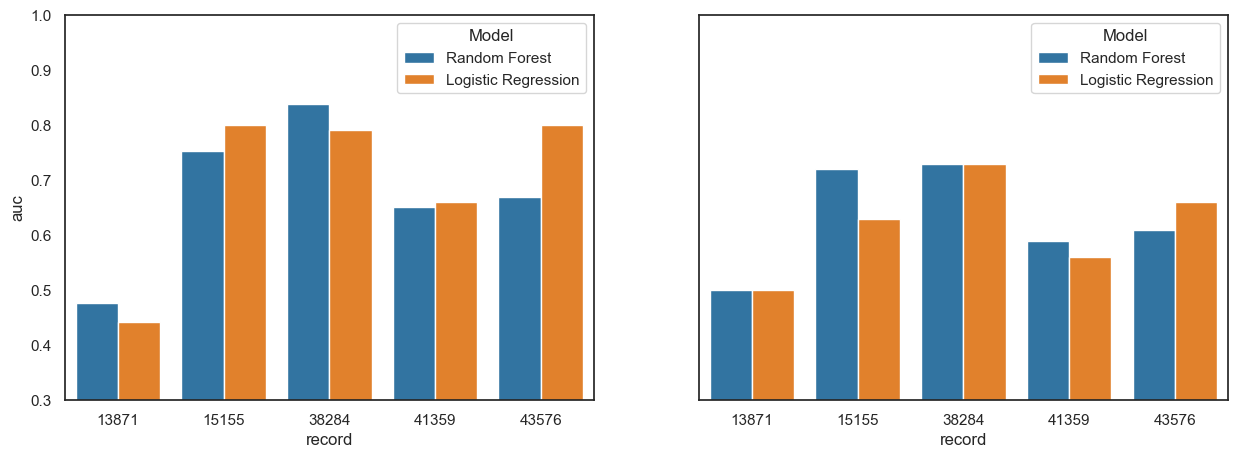

In [16]:
plot_mia_scores(mia_results)